In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


### Get started on this competition through Kaggle Scripts

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). 

Submission Format
Your submission file must have a header and should be structured in the following format:

datetime,count
- 2011-01-20 00:00:00,0
- 2011-01-20 01:00:00,0
- 2011-01-20 02:00:00,0

...
...

## Dataset Description
See, fork, and run a random forest benchmark model through Kaggle Scripts

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

#### Data Fields
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [2]:
# import librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import pylab 
import scipy.stats as stats


In [3]:
# 1.1 Settings of the Notebook

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns',40)
pd.set_option('display.max_rows',100)

import warnings
warnings.filterwarnings(action="ignore")
sns.set(rc={'figure.figsize':[12, 9]},font_scale=1.2)


In [4]:
train = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
test  = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')
Submission = pd.read_csv('/kaggle/input/bike-sharing-demand/sampleSubmission.csv')

In [5]:
train.head()

              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  

In [6]:
test.head()

              datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1  2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2  2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3  2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4  2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014  

In [7]:
train.shape

(10886, 12)

In [8]:
test.shape

(6493, 9)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


## Data Preparing

In [10]:
df = train.copy()

In [11]:
df['year'] = pd.to_datetime(df['datetime']).dt.year
df['quarter'] = pd.to_datetime(df['datetime']).dt.quarter
df['month'] = pd.to_datetime(df['datetime']).dt.month
df['day_of_week'] = pd.to_datetime(df['datetime']).dt.day_of_week
df['hour'] = pd.to_datetime(df['datetime']).dt.hour
df['season'] = df['season'].map({1:'spring',2:'summer',3:'fall',4:'winter'})
df['holiday'] = df['holiday'].map({0:'Not holiday',1:'holiday'})
df['workingday'] = df['workingday'].map({0:'Not workingday',1:'workingday'})
df['weather'] = df['weather'].map({1:'Clear, Few clouds, Partly cloudy, Partly cloudy',
                                   2:'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
                                   3:'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
                                   4:'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'})

In [12]:
df.head()

              datetime  season      holiday      workingday  \
0  2011-01-01 00:00:00  spring  Not holiday  Not workingday   
1  2011-01-01 01:00:00  spring  Not holiday  Not workingday   
2  2011-01-01 02:00:00  spring  Not holiday  Not workingday   
3  2011-01-01 03:00:00  spring  Not holiday  Not workingday   
4  2011-01-01 04:00:00  spring  Not holiday  Not workingday   

                                           weather  temp   atemp  humidity  \
0  Clear, Few clouds, Partly cloudy, Partly cloudy  9.84  14.395        81   
1  Clear, Few clouds, Partly cloudy, Partly cloudy  9.02  13.635        80   
2  Clear, Few clouds, Partly cloudy, Partly cloudy  9.02  13.635        80   
3  Clear, Few clouds, Partly cloudy, Partly cloudy  9.84  14.395        75   
4  Clear, Few clouds, Partly cloudy, Partly cloudy  9.84  14.395        75   

   windspeed  casual  registered  count  year  quarter  month  day_of_week  \
0        0.0       3          13     16  2011        1      1            5

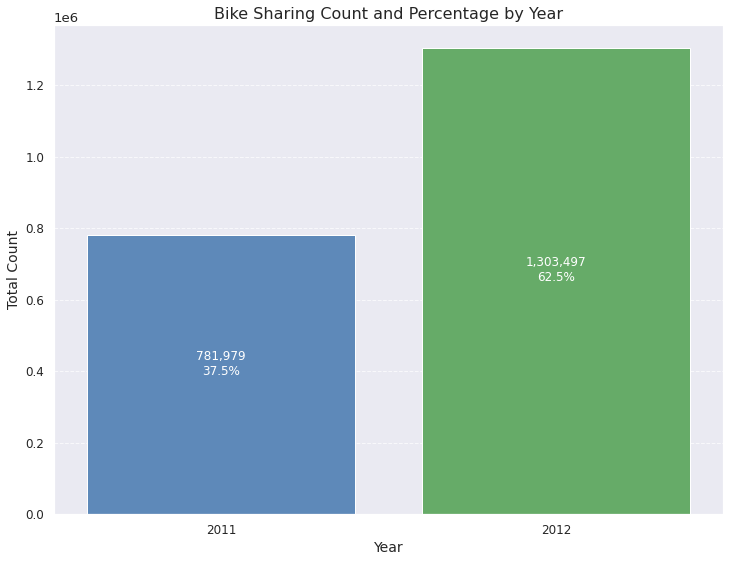

<Figure size 576x432 with 0 Axes>

In [13]:
##   ------------   Bike Shaing count by Year -----------------------

# group the data by year and sum the counts
year_count = df.groupby('year')['count'].sum()

# calculate the percentage of total counts for each year
year_percent = year_count / year_count.sum() * 100

# create a bar plot with custom color palette
colors = ['#4f88c8', '#5bb65d', '#f4b342', '#d9455f']
g = sns.barplot(x=year_count.index, y=year_count.values, palette=colors)

# add value and percentage labels to the bars
for i, (v, p) in enumerate(zip(year_count.values, year_percent.values)):
    g.text(i, v/2, f"{v:,}\n{p:.1f}%", size=12, ha="center", color='white')

# add plot title and axis labels
g.set_title('Bike Sharing Count and Percentage by Year', fontsize=16)
g.set_xlabel('Year', fontsize=14)
g.set_ylabel('Total Count', fontsize=14)

# increase tick label font size
g.tick_params(axis='both', labelsize=12)

# add gridlines to plot
g.grid(axis='y', linestyle='--', alpha=0.7)

# increase figure size
plt.figure(figsize=(8, 6))

plt.show()


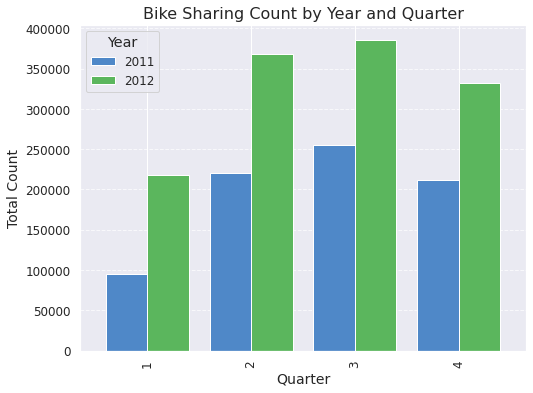

In [14]:
# group the data by year and quarter and sum the counts
year_quarter_count = df.groupby(['year', 'quarter'])['count'].sum()

# plot the data using a pivot table
pivot_table = year_quarter_count.unstack(level=0)
pivot_table.plot(kind='bar', width=0.8, color=['#4f88c8', '#5bb65d', '#f4b342', '#d9455f'])

# add plot title and axis labels
plt.title('Bike Sharing Count by Year and Quarter', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Total Count', fontsize=14)

# add legend and adjust its position
plt.legend(title='Year', fontsize=12, loc='upper left')

# increase tick label font size
plt.tick_params(axis='both', labelsize=12)

# add gridlines to plot
plt.grid(axis='y', linestyle='--', alpha=0.7)

# increase figure size
plt.gcf().set_size_inches(8, 6)

plt.show()


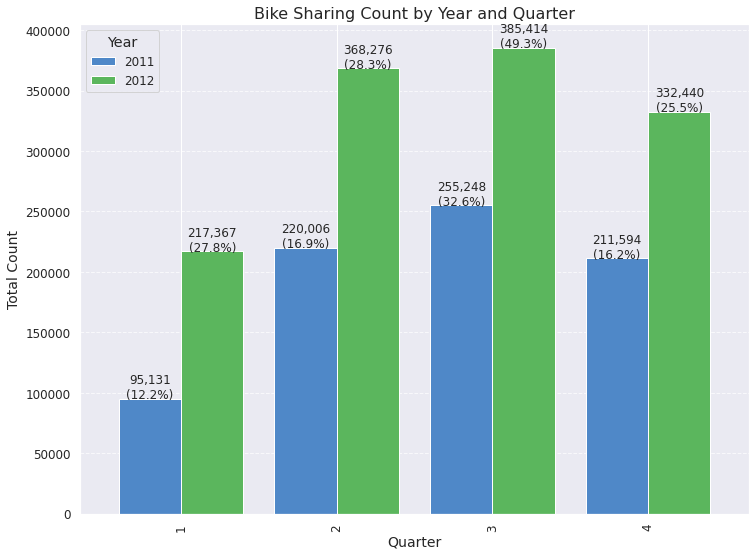

In [15]:
# group the data by year and quarter and sum the counts
year_quarter_count = df.groupby(['year', 'quarter'])['count'].sum()

# plot the data using a pivot table
pivot_table = year_quarter_count.unstack(level=0)
ax = pivot_table.plot(kind='bar', width=0.8, color=['#4f88c8', '#5bb65d', '#f4b342', '#d9455f'])

# add plot title and axis labels
plt.title('Bike Sharing Count by Year and Quarter', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Total Count', fontsize=14)

# add legend and adjust its position
plt.legend(title='Year', fontsize=12, loc='upper left')

# increase tick label font size
plt.tick_params(axis='both', labelsize=12)

# add gridlines to plot
plt.grid(axis='y', linestyle='--', alpha=0.7)

# increase figure size
plt.gcf().set_size_inches(12, 9)

# add count and percentage inside each bar
for i, patch in enumerate(ax.patches):
    year_idx = i % len(pivot_table.columns)
    year = pivot_table.columns[year_idx]
    quarter = pivot_table.index[i // len(pivot_table.columns)]
    count = patch.get_height()
    percentage = count / pivot_table[year].sum() * 100
    ax.text(patch.get_x() + patch.get_width() / 2,
            count + 100,
            f'{count:,}\n({percentage:.1f}%)',
            ha='center',
            fontsize=12)
            
plt.show()


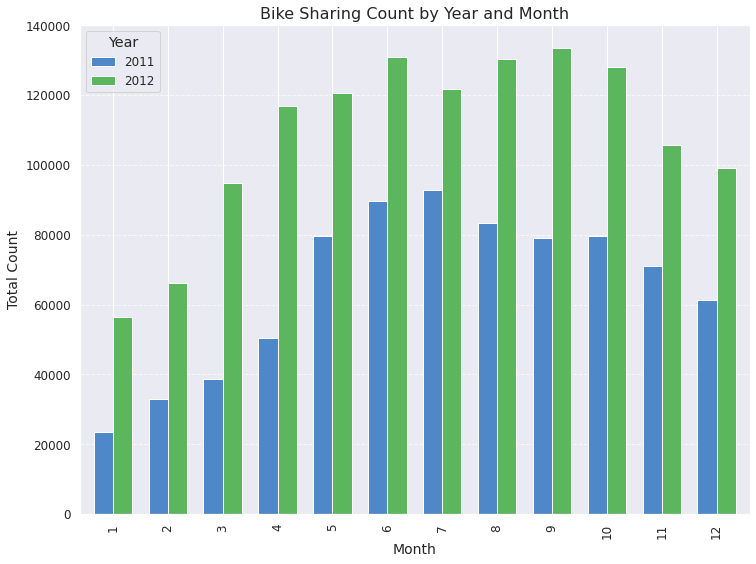

In [16]:
# define custom colors
colors = ['#4f88c8', '#5bb65d', '#f4b342', '#d9455f']

# group the data by year and month and sum the counts
year_month_count = df.groupby(['year', 'month'])['count'].sum()

# plot the data using a pivot table
pivot_table = year_month_count.unstack(level=0)
pivot_table.plot(kind='bar', width=0.7, color=colors)

# add plot title and axis labels
plt.title('Bike Sharing Count by Year and Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Count', fontsize=14)

# add legend and adjust its position
plt.legend(title='Year', fontsize=12, loc='upper left')

# increase tick label font size
plt.tick_params(axis='both', labelsize=12)

# add gridlines to plot
plt.grid(axis='y', linestyle='--', alpha=0.7)

# increase figure size
plt.gcf().set_size_inches(12, 9)

plt.show()


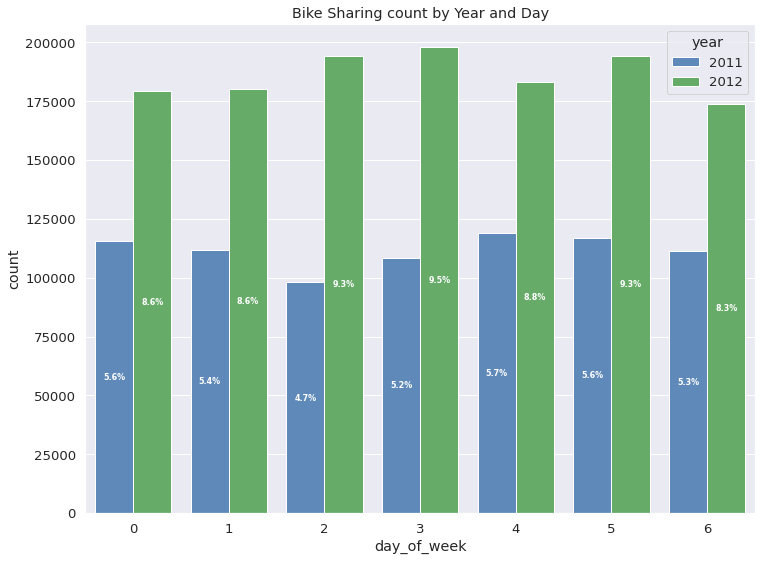

In [17]:
colors = ['#4f88c8', '#5bb65d', '#f4b342', '#d9455f']

year_day_count = df.groupby(['year', 'day_of_week'])['count'].sum().reset_index()

# create the bar plot
ax = sns.barplot(data=year_day_count, x='day_of_week', y='count', hue='year', palette=colors)

# iterate over the bars
for p in ax.patches:
    # get the height and width of the bar
    height = p.get_height()
    width = p.get_width()
    # calculate the percentage value
    percentage = '{:.1f}%'.format(height/sum(year_day_count['count'])*100)
    # add the percentage value inside the bar
    ax.text(x=p.get_x()+width/2, y=height/2, s=percentage, ha='center', va='center', fontsize=8, weight='bold', color='white')

plt.title('Bike Sharing count by Year and Day')
plt.show()

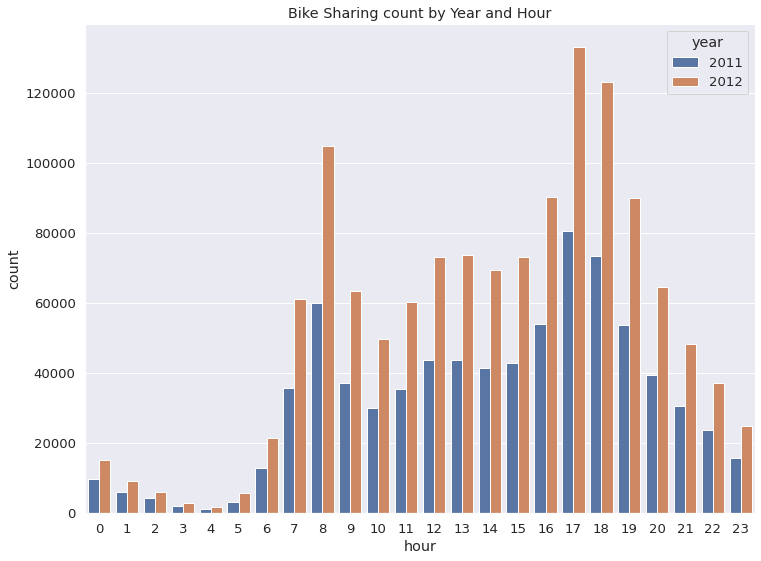

In [18]:
### Bike Shaing count by Hour and Year¶

year_hour_count = df.groupby(['year','hour'])['count'].sum().reset_index()
sns.barplot(data=year_hour_count,x='hour',y='count',hue='year')
plt.title('Bike Sharing count by Year and Hour')
plt.show()